In [ ]:
%pip install ortools
!pip install matplotlib
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.2

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def create_data_model():
    data = {}
    data["distance_matrix"] = [
        # fmt: off
        [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
        [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
        [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
        [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
        [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
        [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
        [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
        [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
        [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
        [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
        [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
        [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
        [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
        [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
        [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
        [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
        [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["distance_matrix"] = [[j*10 for j in i] for i in data["distance_matrix"]]
    data["demands"] = [0, 2, 4, 6, 4, 39, 6, 8, 8, 5, 3, 4, 10, 7, 4, 8, 4]
    data["vehicle_capacities"] = [33,22,54,40]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data

In [ ]:
def solve_cvrp(data, heuristic, metaheuristic):
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]), data["num_vehicles"], data["depot"])

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,
        data["vehicle_capacities"],
        True,
        "Capacity",
    )

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = heuristic
    if (metaheuristic!=None):
        search_parameters.local_search_metaheuristic = metaheuristic
    search_parameters.time_limit.FromSeconds(2)

    solution = routing.SolveWithParameters(search_parameters)

    return solution.ObjectiveValue() if solution else 0

In [ ]:
def old_plot_results(results):
    heuristicmap = {routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC:"PATH_CHEAPEST_ARC",routing_enums_pb2.FirstSolutionStrategy.PATH_MOST_CONSTRAINED_ARC:"PATH_MOST_\nCONSTRAINED_ARC",routing_enums_pb2.FirstSolutionStrategy.SAVINGS:"SAVINGS",routing_enums_pb2.FirstSolutionStrategy.CHRISTOFIDES:"CHRISTOFIDES",routing_enums_pb2.FirstSolutionStrategy.BEST_INSERTION:"BEST_INSERTION",routing_enums_pb2.FirstSolutionStrategy.SWEEP:"SWEEP"}
    metaheuristicsmap={None:"None",routing_enums_pb2.LocalSearchMetaheuristic.GREEDY_DESCENT:"GREEDY_DESCENT",routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH:"GUIDED_LOCAL_SEARCH",routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING:"SIMULATED_ANNEALING",routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH:"TABU_SEARCH"}
    heuristics = list(results.keys())
    metaheuristics = list(results[heuristics[0]].keys())

    bar_width = 0.15
    x = np.arange(len(heuristics))

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, metaheuristic in enumerate(metaheuristics):
        ax.bar(x + i * bar_width, [results[h][metaheuristic] for h in heuristics],
               width=bar_width, label=metaheuristicsmap[metaheuristic])

    ax.set_xlabel('Heuristics')
    ax.set_ylabel('Distance(meters) (Lower is Better)')
    ax.set_title('Comparison of Heuristics and Metaheuristics for CVRP')
    ax.set_xticks(x + bar_width * (len(metaheuristics) - 1) / 2)
    ax.set_xticklabels(heuristicmap.values())
    ax.legend(title='Metaheuristics')

    plt.tight_layout()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_results(results):
    heuristicmap = {
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC: "PATH_CHEAPEST_ARC",
        routing_enums_pb2.FirstSolutionStrategy.PATH_MOST_CONSTRAINED_ARC: "PATH_MOST_\nCONSTRAINED_ARC",
        routing_enums_pb2.FirstSolutionStrategy.SAVINGS: "SAVINGS",
        routing_enums_pb2.FirstSolutionStrategy.CHRISTOFIDES: "CHRISTOFIDES",
        routing_enums_pb2.FirstSolutionStrategy.BEST_INSERTION: "BEST_INSERTION",
        routing_enums_pb2.FirstSolutionStrategy.SWEEP: "SWEEP"
    }

    metaheuristicsmap = {
        None: "None",
        routing_enums_pb2.LocalSearchMetaheuristic.GREEDY_DESCENT: "GREEDY_DESCENT",
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH: "GUIDED_LOCAL_SEARCH",
        routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING: "SIMULATED_ANNEALING",
        routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH: "TABU_SEARCH"
    }

    heuristics = list(results.keys())
    metaheuristics = list(results[heuristics[0]].keys())


    sns.set(style="darkgrid")

    palette = sns.color_palette("pastel", len(metaheuristics))

    bar_width = 0.15
    x = np.arange(len(heuristics))

    fig, ax = plt.subplots(figsize=(14, 8))

    for i, metaheuristic in enumerate(metaheuristics):
        ax.bar(
            x + i * bar_width,
            [results[h][metaheuristic] for h in heuristics],
            width=bar_width,
            label=metaheuristicsmap[metaheuristic],
            color=palette[i]
        )

    ax.set_xlabel('Heuristics', fontsize=14, labelpad=15)
    ax.set_ylabel('Distance (meters) (Lower is Better)', fontsize=14, labelpad=15)
    ax.set_title('Comparison of Heuristics and Metaheuristics for CVRP', fontsize=16, pad=20)
    ax.set_xticks(x + bar_width * (len(metaheuristics) - 1) / 2)
    ax.set_xticklabels([heuristicmap[h] for h in heuristics], fontsize=12, rotation=45)

    ax.legend(title='Metaheuristics', title_fontsize='13', fontsize='11', loc='upper right')

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
def main():
    data = create_data_model()

    heuristics = [
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC,
        routing_enums_pb2.FirstSolutionStrategy.PATH_MOST_CONSTRAINED_ARC,
        routing_enums_pb2.FirstSolutionStrategy.SAVINGS,
        routing_enums_pb2.FirstSolutionStrategy.CHRISTOFIDES,
        routing_enums_pb2.FirstSolutionStrategy.BEST_INSERTION,
        routing_enums_pb2.FirstSolutionStrategy.SWEEP
    ]

    metaheuristics = [
        None,
        routing_enums_pb2.LocalSearchMetaheuristic.GREEDY_DESCENT,
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
        routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING,
        routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH
    ]

    results = {}

    for heuristic in heuristics:
        heuristic_name = heuristic
        results[heuristic_name] = {}
        for metaheuristic in metaheuristics:
            metaheuristic_name = metaheuristic
            objective_value = solve_cvrp(data, heuristic, metaheuristic)
            results[heuristic_name][metaheuristic_name] = objective_value


    print(results)

    plot_results(results)

{3: {None: 58440, 1: 58440, 2: 53200, 3: 56600, 4: 58440}, 4: {None: 62320, 1: 62320, 2: 53200, 3: 62320, 4: 62320}, 10: {None: 64160, 1: 64160, 2: 53200, 3: 56840, 4: 59800}, 13: {None: 60040, 1: 60040, 2: 53200, 3: 55480, 4: 60040}, 7: {None: 0, 1: 0, 2: 0, 3: 0, 4: 0}, 11: {None: 0, 1: 0, 2: 0, 3: 0, 4: 0}}


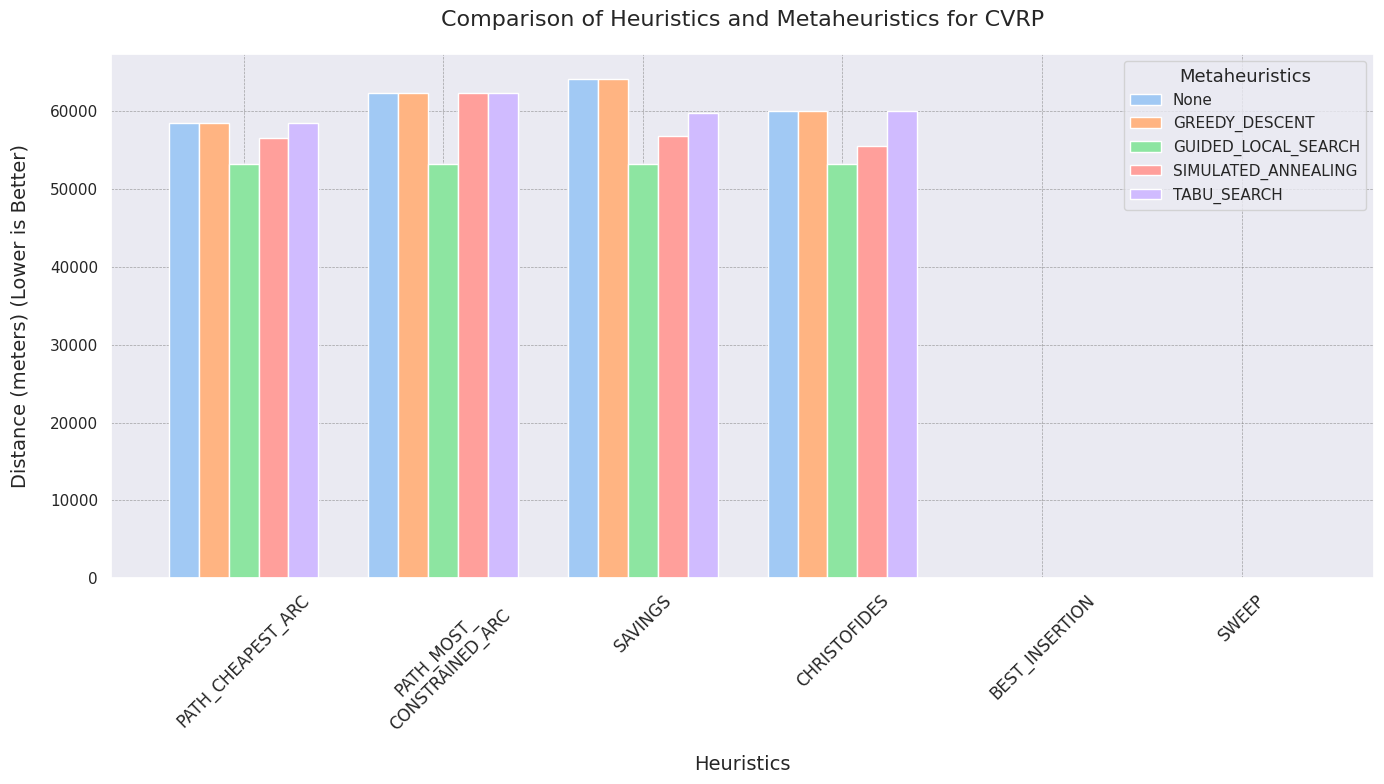

In [ ]:
main()